In [2]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [58]:
smpl_img = mndata.train_images[1]
img_arr = np.array(smpl_img).reshape(28, 28)
img_arr= img_arr / 255
for img_row in img_arr:
    print(img_row.tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.6235294117647059, 0.9921568627450981, 0.6235294117647059, 0.19607843137254902, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18823529411764706, 0.9333333333333333, 0.9882352941176471, 0.9882352941176471, 0.9882352941176471, 0.9294117647058824, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0

In [3]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in range(10):
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

100

In [103]:
layer_size = 10*4

mu=0.0
sigma=1.0

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
# W = np.random.rand(O.size, I.size) * 0.001
W = np.random.normal(mu, sigma, (O.size, I.size))
print('W', W.shape, W.max(), W.min(), np.median(W))

T = np.zeros(O.shape)

k = 1
push_delta = 0.4

prec = 1e-30

epoch_cnt = 100
eps0 = 0.02

speed_T = 1
inc_T = 0.03 * speed_T
dec_T = 0.001 * speed_T
flr_T = 0

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    np.random.shuffle(samples_idx)

    for i_idx in samples_idx:
        img = mndata.train_images[i_idx]
        # I = np.abs(np.array(img) - 255) / 255
        I = np.array(img) / 255

        # infer
        O = np.dot(W, I)
        

        # threshold
        # TO = np.copy(O)
        # O[np.where(O < T)] = flr_T - prec
        # if np.max(TO) > np.min(O):
        #     O = TO
        # print(f'{np.sum(O >= T)=}')
        # print(f'{np.where(O >= T)=}')

        # train
        D = np.zeros(O.shape)

        # if np.sum(O >= T) == 0:
        #     # re-infer
        #     O = np.dot(W, I)

        #     winner_ids = np.argsort(O)[::-1]

        #     D[winner_ids[0]] = 1
        #     T[winner_ids[0]] = O[winner_ids[0]]
        # else:
        winner_ids = np.argsort(O)[::-1]

        D[winner_ids[0]] = 1
        D[winner_ids[1:1+k]] += -push_delta
        
        D = D[np.newaxis].T
        
        # norm O
        # O /= np.max(np.abs(O))
        # O /= np.linalg.norm(O, ord=2)
        # print(f'{O.tolist()=}')
        
        dW = I - (W * O[np.newaxis].T)

        # norm
        # nc = np.max(np.abs(dW))
        nc = np.linalg.norm(dW, ord=1)
        # # nc = np.linalg.norm(dW, axis=1, ord=1)
        # nc[np.where(nc < prec)] = prec
        # nc = nc[np.newaxis].T
        if nc < prec:
            nc = prec
        dW /= nc

        # print(f'{np.sum(dW < 0)=}')

        # update
        W += dW * D * eps
        
        # train T
        dT = np.zeros(T.shape)
        dT += -dec_T
        dT[winner_ids[0]] = inc_T
        dT[winner_ids[1:1+k]] = 0

        # update T
        T += dT * eps
        T[np.where(T < flr_T)] = flr_T

print('W', W.shape, W.max(), W.min(), np.median(W))
print('T', T.shape, T.max(), T.min(), np.median(T))
print(T.tolist())

W (40, 784) 3.879006039798626 -4.007742081249322 -0.013461156027921656
W (40, 784) 9.094381511875811 -8.662489798409606 0.0004724572994947822
T (40,) 16.226020000000354 0.0 0.0008899999999999965
[2.302039999999983, 0.0008399999999999992, 0.0, 0.0, 0.0, 0.008159999999999942, 0.0, 0.008920000000000166, 0.0, 0.0009399999999999938, 0.0005399999999999982, 2.277319999999988, 2.977199999999994, 0.6033199999999997, 0.008360000000000093, 0.0, 8.591599999999909, 0.0050199999999998935, 0.010780000000000019, 0.0, 0.0, 0.0, 8.885799999999865, 0.0, 1.4760200000000192, 0.0002599999999999997, 0.0, 0.01507999999999986, 0.007360000000000025, 1.2130000000000025, 0.0, 4.423220000000042, 9.794179999999983, 0.00011999999999999636, 0.00015999999999999863, 16.226020000000354, 0.0004799999999999933, 0.0, 0.0005799999999999999, 0.007299999999999929]


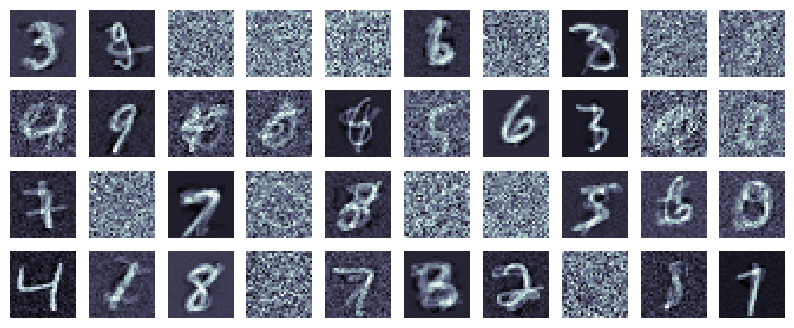

In [104]:
row_size = 10
col_size = int(layer_size / row_size)

figure(figsize=(row_size, col_size))

for col_idx in range(col_size):
    for row_idx in range(row_size):
        n_W_idx = col_idx * row_size + row_idx

        aimg = W[n_W_idx].reshape(img_side, img_side)

        subplot(col_size, row_size, n_W_idx + 1)

        imshow(aimg,
               interpolation='none',
               aspect='auto',
               cmap='bone',  # seismic
            #    vmax=1,
            #    vmin=-1,
                #   vmax=np.max(np.abs(aimg)),
                #   vmin=-np.max(np.abs(aimg))
               )
        axis("off")

show()